<a href="https://colab.research.google.com/github/m-mehabadi/grad-maker/blob/main/_notebooks/Testing_GradientMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/dual-ascent.pdf

In [1]:
import numpy as np
# import torch
import matplotlib.pyplot as plt

In [2]:
# dim=2000000
# a = 100*np.random.randn(4, dim) + 1123
# g = np.random.randn(dim, 1)
# b = (a-np.mean(a, axis=1)[:, np.newaxis])/np.std(a, axis=1)[:, np.newaxis]
# np.mean(b@g/dim)

In [66]:
def gradient_maker(domain_grads, epsilon=0.5, alpha=0.01, eff=0.1):
    ###### NOTES:
    ### make sure that `domain_grads` dtype is float precision not integer or long.

    def log():
        print(f"g={g}")
        print(f"Iter={iter}, Condition={np.min(dgr@g/dim)}")
    
    # def null(A, eps=1e-15):
    #     u, s, vh = np.linalg.svd(A)
    #     # print(vh)
    #     null_space = np.compress(s <= eps, vh, axis=0)
    #     return null_space.T

    def null(A):
        from scipy.linalg import null_space
        n = null_space(A, rcond=1)
        if n.shape[1] < 1:
            return False, None
        r = np.sqrt(np.sum((A@n)**2, axis=0)/n.shape[1])
        if np.min(r) >= 1e-2:
            return False, None
        return True, n.T[np.argmin(r)].reshape(-1, 1)
    
    def scale():
        G = np.concatenate((g.reshape(1, -1), domain_grads), axis=0)
        is_fine, n = null(G@G.T)
        if not is_fine:
            return np.mean(np.sqrt(np.sum(domain_grads**2, axis=1)))/np.sqrt(np.sum(g**2))
        print(n)
        n /= np.sum(n[1:])
        print(n)
        return np.abs(n[0,0])

    dgr = np.copy(domain_grads)
    number_of_domains, dim = dgr.shape

    #
    dgr /= np.sqrt(np.sum(dgr**2, axis=1))[:, np.newaxis]
    
    #
    g = np.random.randn(dim)
    g /= np.sqrt(np.sum(g**2))
    u_ = np.zeros(number_of_domains)
    
    iter = 0
    while not np.min(dgr@g/dim) >= epsilon:

        log()
        
        u_ = u_ + alpha*((1.+eff)*epsilon - (dgr@g)/dim)
        g = (1./number_of_domains)*np.sum(((1+u_).reshape(number_of_domains, 1))*dgr, axis=0)

        iter += 1
    
    log()
    return scale()*g

### Testcases

Now let's write some test cases to make sure everything is working correctly


In [25]:
epsilon=0
alpha=0.9

In [83]:
# grads = 0.0000001*np.random.randn(2, 3) - 10000000
grads = np.array([[1., 0], [1, 5]])#, [0, 1]])
print(grads)

[[1. 0.]
 [1. 5.]]


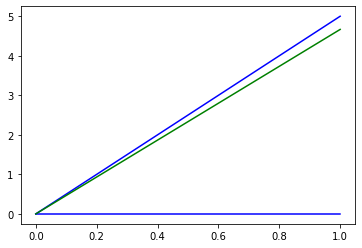

In [85]:
AA = grads
AA_g = g

px = np.array([0, AA[0][0].item()])
py = np.array([0, AA[0][1].item()])

px2 = np.array([0, AA[1][0].item()])
py2 = np.array([0, AA[1][1].item()])

px3 = np.array([0, AA_g[0].item()])
py3 = np.array([0, AA_g[1].item()])

plt.plot(px, py, 'blue')
plt.plot(px2, py2, 'blue')
plt.plot(px3, py3, 'green')
plt.show()

In [84]:
g = gradient_maker(grads, epsilon=epsilon, alpha=alpha)
print(g)

g=[0.20953182 0.97780183]
Iter=0, Condition=0.1047659095196519
[[ 0.98131738]
 [-0.01371043]
 [-0.19190679]]
[[-4.77254483]
 [ 0.06667939]
 [ 0.93332061]]
[1.         4.66660307]


In [80]:
aa = np.array(
[[ 0.12486324],
 [ 0.16834538],
 [-0.21992362],
 [ 1.05157825]]
)

In [82]:
np.sum(aa[1:]*grads, axis=0)+g

array([6.05537117e-09, 1.59298125e-08])